In [1]:
import io
import os
import re
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


# Currently working on: HLA comparison

In [ ]:
def remove_superscripts(s):
    pattern = r'[:X\d]'
    matches = re.findall(pattern, s)
    result = ''.join(matches)
    return result

def resolve_ambiguous_hla_type(r):
    if pd.isna(r['Included Alleles']):
        r['Included Alleles'] = remove_superscripts(r['G code'])
    alleles = r['Included Alleles'].split('/')
    one_field = list(set([":".join(i.split(':', 1)[:1]) for i in alleles]))
    two_field = list(set([":".join(i.split(':', 2)[:2]) for i in alleles]))
    r['One field1'] =  '/'.join(one_field)
    r['Two field1'] = '/'.join(two_field)
    return r

def check_letter(s):
    for c in s:
        if c.isalpha():
            return True

def check_column(s):
    if ':' in s:
        return True

def clean_hla(r, locis = locis):
    for i in locis:
        allele = r[i]
        if check_letter(allele) or not check_column(allele):
            r[i] = '-9'
        else:
            r[i] = ":".join(allele.split(':', 2)[:2])
    return r

def compare_hla_types(r):
    typed = set(r[['A1', 'A2']])
    imputed = set(r[['bestallele1', 'bestallele2']])
    if typed == imputed:
        r['match'] = 2
    else:
        r['match'] = len(typed.intersection(imputed))
    return r

def check_one_field_match(typed, imputed, ix):
    colnames = ['One field1', 'One field2']
    typedalleles = set(typed.loc[ix, colnames])
    imputedalleles = set(imputed.loc[ix, colnames])
    if typedalleles == imputedalleles:
        typed.loc[ix, 'One field match'] = 2
    else:
        typed.loc[ix, 'One field match'] = len(typedalleles.intersection(imputedalleles))
    return typed

def check_two_field_match(typed, imputed, ix):
    colnames = ['Two field1', 'Two field2']
    typedallele1 = typed.loc[ix, 'Two field1'].split('/')
    typedallele2 = typed.loc[ix, 'Two field2'].split('/')
    imputedallele1 = imputed.loc[ix, 'Two field1']
    imputedallele2 = imputed.loc[ix, 'Two field2']
    
    typed.loc[ix, 'Two field match'] = max(np.sum((imputedallele1 in typedallele1) + (imputedallele2 in typedallele2)), np.sum((imputedallele2 in typedallele1) + (imputedallele1 in typedallele2)))
    return typed

def compare_hla_types(typed, imputed):
    typed = typed.copy()
    typed['One field match'] = 0
    typed['Two field match'] = 0
    for ix in range(len(typed)):
        typed = check_one_field_match(typed, imputed, ix)
        typed = check_two_field_match(typed, imputed, ix)   
    return typed

In [163]:
loci = ['A', 'B', 'C', 'DQB1', 'DRB1']
locis = [i+'1' for i in loci] + [i+'2' for i in loci]

hla = pd.read_csv('/well/band/users/rbx225/GAMCC/data/hla_direct_sequencing/HLA_direct_sequencing_all.csv')
hla = hla[['SampleID', 'Locus', 'Included Alleles', 'G code']]
hla = hla[hla['Locus'].isin(loci)].reset_index(drop = True)
hla['One field1'] = ''
hla['Two field1'] = ''

hla = hla.apply(resolve_ambiguous_hla_type, axis = 1)
hla = hla.drop(columns = ['Included Alleles', 'G code'])

sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
sample_linker = sample_linker[~sample_linker['Sample_Name'].str.contains('mini')]
fv = list(sample_linker['Chip_Name'].values)
hla = hla[hla['SampleID'].isin(fv)].reset_index(drop = True)

for s in hla['SampleID'].unique():
    tmps = hla[hla['SampleID'] == s]
    for l in loci:
        tmpl = tmps[tmps['Locus'] == l]
        repeat = 2 - tmpl.shape[0]
        if repeat == 2:
            hla.loc[len(hla)] = [s, l, '-9', '-9']
            hla.loc[len(hla)] = [s, l, '-9', '-9']
        if repeat == 1:
            hla.loc[len(hla)] = [s, l, tmpl.iloc[0,2], tmpl.iloc[0, 3]]
hla = hla.sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
hla = pd.concat([hla.iloc[::2].reset_index(drop=True), hla.iloc[1::2, 2:].reset_index(drop=True)], axis=1)
hla.columns = ['SampleID', 'Locus', 'One field1', 'Two field1', 'One field2', 'Two field2']
hla

,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,A,02,02:01,02,02:01
1,GAM013489,B,44,44:03,82,82:01
2,GAM013489,C,03,03:02,03,03:03
3,GAM013489,DQB1,02,02:02/02:156,05,05:02/05:241
4,GAM013489,DRB1,09,09:01/09:31,16,16:02
...,...,...,...,...,...,...
1045,GAM975418,A,29,29:02,33,33:01
1046,GAM975418,B,07,07:02,07,07:02
1047,GAM975418,C,15,15:05,15,15:05
1048,GAM975418,DQB1,04,04:02/04:87,05,05:263/05:237/05:01


In [165]:
sample_linker = pd.read_csv('data/metadata/sample_linker.csv')
idt_to_exclude = list(sample_linker[sample_linker['Sample_Name'].str.contains('mini')]['Seq_Name'].values)
sample_linker = {k:v for k, v in zip(sample_linker['Seq_Name'], sample_linker['Chip_Name'])}

imputed_lst = []
for g in loci:
    imputed = pd.read_csv('/well/band/users/rbx225/GAMCC/results/hla/imputation/genes/' + g + '/quilt.hla.output.combined.topresult.txt', sep = '\t')
    imputed = imputed[['sample_name', 'bestallele1', 'bestallele2', 'post_prob']]
    imputed['Locus'] = g
    imputed.columns = ['SampleID', 'Two field1', 'Two field2', 'prob', 'Locus']
    imputed['One field1'] = imputed['Two field1'].str.split('*').str.get(1).str.split(':').str.get(0)
    imputed['One field2'] = imputed['Two field2'].str.split('*').str.get(1).str.split(':').str.get(0)
    imputed['Two field1'] = imputed['Two field1'].str.split('*').str.get(1)
    imputed['Two field2'] = imputed['Two field2'].str.split('*').str.get(1)
    imputed = imputed[~imputed['SampleID'].isin(idt_to_exclude)]
    imputed['SampleID'] = imputed['SampleID'].apply(lambda x: sample_linker[x])
    imputed_lst.append(imputed)
imputed = pd.concat(imputed_lst).sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
imputed = imputed[['SampleID', 'Locus', 'One field1', 'Two field1', 'One field2', 'Two field2', 'prob']]
imputed

,SampleID,Locus,One field1,Two field1,One field2,Two field2,prob
0,GAM013489,A,02,02:01,02,02:01,0.978304
1,GAM013489,B,44,44:03,82,82:01,0.999988
2,GAM013489,C,03,03:03,03,03:02,0.999898
3,GAM013489,DQB1,02,02:02,05,05:02,0.999999
4,GAM013489,DRB1,07,07:01,16,16:02,0.370618
...,...,...,...,...,...,...,...
1045,GAM975418,A,29,29:02,68,68:02,0.398663
1046,GAM975418,B,07,07:02,07,07:02,0.999996
1047,GAM975418,C,15,15:05,15,15:05,1.000000
1048,GAM975418,DQB1,05,05:01,04,04:02,1.000000


In [178]:
def calculate_hla_concordance(df):
    ccd_one = df['One field match'].sum()/(df.shape[0]*2)
    ccd_two = df['Two field match'].sum()/(df.shape[0]*2)
    return [ccd_one, ccd_two]

def generate_hla_imputation_report(df, source, loci = loci):
    report = pd.DataFrame(columns = ['Locus', 'Concordance', 'Resolution', 'Source'])
    for l in loci:
        tmp = df[df['Locus'] == l]
        ccd = calculate_hla_concordance(tmp)
        report.loc[len(report)] = [l, ccd[0], 'One field', source]
        report.loc[len(report)] = [l, ccd[1], 'Two field', source]
    return report

In [203]:
true_imp = compare_hla_types(hla, imputed)
lc_hla_report = generate_hla_imputation_report(true_imp, 'low-coverage')

In [153]:
vcf = lcwgsus.read_vcf('/well/band/users/rbx225/GAMCC/results/hla/server/chr6.dose.vcf.gz')
vcf = vcf[vcf['ID'].str.contains('HLA')]
vcf = vcf[VCF_COLS + list(vcf.columns[vcf.columns.isin(fv)])]
samples = list(vcf.columns[9:])
for i in samples:
    vcf[i] = vcf[i].apply(lcwgsus.encode_hla)
vcf = vcf.drop(columns = COMMON_COLS + ['QUAL', 'FILTER', 'INFO', 'FORMAT'])
vcf['Locus'] = vcf['ID'].str.split('*').str.get(0).str.split('_').str.get(1)
vcf['ID'] = vcf['ID'].str.split('*').str.get(1)
vcf = vcf[vcf['Locus'].isin(loci)]
vcf = vcf[['Locus', 'ID'] + samples].reset_index(drop = True)

combinations = list(itertools.product(samples, loci))
df = pd.DataFrame(combinations, columns=['SampleID', 'Locus'])
df['One field1'] = '-9'
df['Two field1'] = '-9'
df['One field2'] = '-9'
df['Two field2'] = '-9'

df = df.set_index(['SampleID', 'Locus'])

for s in samples:
    tmp = vcf[vcf[s] != 0][['Locus', 'ID', s]]
    
    onefield = tmp[tmp['ID'].str.split(':').str.len() == 1].reset_index(drop = True)
    twofield = tmp[tmp['ID'].str.split(':').str.len() == 2].reset_index(drop = True)
    
    for i in range(len(onefield.index)):
        l = onefield.loc[i, 'Locus']
        ID = onefield.loc[i, 'ID']
        dosage = onefield.loc[i, s]
        if dosage == 2:
            df.loc[(s, l), 'One field1'] = ID
            df.loc[(s, l), 'One field2'] = ID
        else:
            if df.loc[(s, l), 'One field1'] == '-9':
                df.loc[(s, l), 'One field1'] = ID
            else:
                df.loc[(s, l), 'One field2'] = ID
        
    for i in range(len(twofield.index)):
        l = twofield.loc[i, 'Locus']
        ID = twofield.loc[i, 'ID']
        dosage = twofield.loc[i, s]
        if dosage == 2:
            df.loc[(s, l), 'Two field1'] = ID
            df.loc[(s, l), 'Two field2'] = ID
        else:
            if df.loc[(s, l), 'Two field1'] == '-9':
                df.loc[(s, l), 'Two field1'] = ID
            else:
                df.loc[(s, l), 'Two field2'] = ID

df = df.reset_index().sort_values(by = ['SampleID', 'Locus'])
df

/tmp/slurm-57181430/ipykernel_85367/3458355341.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  vcf['Locus'] = vcf['ID'].str.split('*').str.get(0).str.split('_').str.get(1)


,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,A,02,02:01,02,02:01
1,GAM013489,B,44,44:03,82,82:01
2,GAM013489,C,03,03:02,03,03:03
3,GAM013489,DQB1,02,02:01,05,05:02
4,GAM013489,DRB1,09,09:01,16,16:02
...,...,...,...,...,...,...
925,GAM975418,A,29,29:02,33,33:01
926,GAM975418,B,07,07:02,07,07:02
927,GAM975418,C,15,15:05,15,15:05
928,GAM975418,DQB1,04,04:02,05,05:01


In [206]:
chip_hla = hla[hla['SampleID'].isin(samples)].sort_values(by = ['SampleID', 'Locus']).reset_index(drop = True)
true_chip = compare_hla_types(chip_hla, df)
chip_hla_report = generate_hla_imputation_report(true_chip, 'chip')

In [207]:
report = pd.concat([lc_hla_report, chip_hla_report])
report

,Locus,Concordance,Resolution,Source
0,A,0.852381,One field,low-coverage
1,A,0.785714,Two field,low-coverage
2,B,0.964286,One field,low-coverage
3,B,0.930952,Two field,low-coverage
4,C,0.988095,One field,low-coverage
5,C,0.976190,Two field,low-coverage
6,DQB1,0.997619,One field,low-coverage
7,DQB1,0.971429,Two field,low-coverage
8,DRB1,0.647619,One field,low-coverage
9,DRB1,0.530952,Two field,low-coverage


<Axes: xlabel='Concordance', ylabel='Locus'>

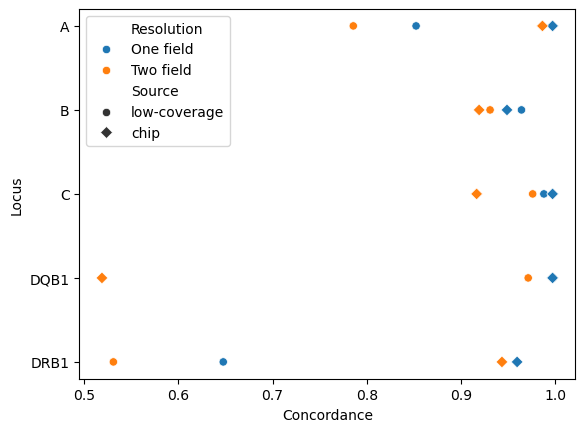

In [209]:
sns.scatterplot(data=report, x='Concordance', y='Locus', hue='Resolution', style='Source', markers={'low-coverage': 'o', 'chip': 'D'})

In [191]:
df[df['Locus'].str.contains('DQB')].reset_index(drop = True)

,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,DQB1,02,02:01,05,05:02
1,GAM013627,DQB1,05,05:01,05,05:01
2,GAM013795,DQB1,03,03:01,03,03:02
3,GAM015283,DQB1,03,03:01,05,05:01
4,GAM018372,DQB1,03,03:01,05,05:01
...,...,...,...,...,...,...
181,GAM942670,DQB1,04,04:02,05,05:01
182,GAM946580,DQB1,05,05:01,05,05:01
183,GAM951206,DQB1,03,03:01,05,05:01
184,GAM967203,DQB1,02,02:01,02,02:01


In [194]:
chip_hla[chip_hla['Locus'].str.contains('DQB')].reset_index(drop = True)

,SampleID,Locus,One field1,Two field1,One field2,Two field2
0,GAM013489,DQB1,02,02:02/02:156,05,05:02/05:241
1,GAM013627,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01
2,GAM013795,DQB1,03,03:19,03,03:289/03:02/03:484/03:493/03:416
3,GAM015283,DQB1,03,03:19,05,05:263/05:237/05:01
4,GAM018372,DQB1,03,03:19,05,05:263/05:237/05:01
...,...,...,...,...,...,...
181,GAM942670,DQB1,04,04:02/04:87,05,05:263/05:237/05:01
182,GAM946580,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01
183,GAM951206,DQB1,03,03:19,05,05:263/05:237/05:01
184,GAM967203,DQB1,02,02:02/02:156,02,02:02/02:156


In [196]:
x = compare_hla_types(chip_hla, df)[compare_hla_types(chip_hla, df)['Locus'] == 'DQB1']
x

,SampleID,Locus,One field1,Two field1,One field2,Two field2,One field match,Two field match
3,GAM013489,DQB1,02,02:02/02:156,05,05:02/05:241,2,0
8,GAM013627,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01,2,0
13,GAM013795,DQB1,03,03:19,03,03:289/03:02/03:484/03:493/03:416,2,0
18,GAM015283,DQB1,03,03:19,05,05:263/05:237/05:01,2,0
23,GAM018372,DQB1,03,03:19,05,05:263/05:237/05:01,2,0
...,...,...,...,...,...,...,...,...
908,GAM942670,DQB1,04,04:02/04:87,05,05:263/05:237/05:01,2,0
913,GAM946580,DQB1,05,05:263/05:237/05:01,05,05:263/05:237/05:01,2,0
918,GAM951206,DQB1,03,03:19,05,05:263/05:237/05:01,2,0
923,GAM967203,DQB1,02,02:02/02:156,02,02:02/02:156,2,0


In [198]:
x['One field match'].sum()/372

0.9973118279569892